In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
data  = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [82]:
#!wget $data 

--2024-10-07 17:27:32--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.07s   

2024-10-07 17:27:33 (4.30 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [83]:

df = pd.read_csv('laptops.csv.1')
df.columns = df.columns.str.lower().str.replace(' ', '_')
column_list = ['ram','storage','screen','final_price']
df = df[column_list]

df.head() 

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: >

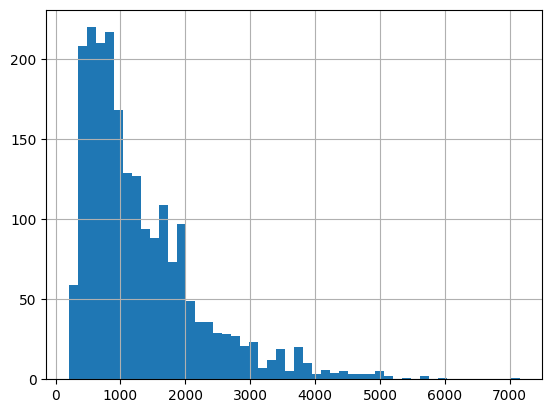

In [84]:
df.final_price.hist(bins=50)

Price distribution even visually has a heavy right tail

# Q1 Looking for missing values

In [98]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)
missing_column = missing_columns.index[0]

screen    4
dtype: int64


# Q2 median calculation

In [99]:
# Calculate the median value for the 'ram' column
ram_median = df['ram'].median()

print(f"The median value for 'ram' is: {ram_median}")


The median value for 'ram' is: 16.0


# Setting up split and shuffle routine

In [100]:
def df_shuffle_and_split(df, random_seed=42):
    n = len(df)
    
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(random_seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train['final_price'].values
    y_val = df_val['final_price'].values
    y_test = df_test['final_price'].values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, df_val, df_test, y_train, y_val, y_test


# defining linear regression and error fucntion 

In [101]:
def train_linear_regression(X, y):
    # Add a column of ones to X to account for the bias term (intercept w0)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    return w[0], w[1:]  

In [102]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


# Q3 training pure linear regresssion

In [106]:

# Fill missing values with 0 and train model
def fill_missing_with_0(df_train, df_val, nan_column, y_train, y_val):
    # Fill missing values in the train and validation sets
    df_train[nan_column] = df_train[nan_column].fillna(0)
    df_val[nan_column] = df_val[nan_column].fillna(0)
    
    # Train the model
    w0, w = train_linear_regression(df_train.values, y_train)
    
    # Make predictions
    y_pred = w0 + df_val.dot(w)
    
    # Return the RMSE
    return rmse(y_val, y_pred)

# Fill missing values with mean (computed from training data) and train model
def fill_missing_with_mean(df_train, df_val, nan_column, y_train, y_val):
    # Compute the mean from the training set
    mean_value = df_train[nan_column].mean()
    
    # Fill missing values in the train and validation sets
    df_train[nan_column] = df_train[nan_column].fillna(mean_value)
    df_val[nan_column] = df_val[nan_column].fillna(mean_value)
    
    # Train the model
    w0, w = train_linear_regression(df_train.values, y_train)
    
    # Make predictions
    y_pred = w0 + df_val.dot(w)
    
    # Return the RMSE
    return rmse(y_val, y_pred)

df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df, random_seed=42)

# Identify the column with missing values (from Q1)
nan_column = nan_columns[0]
rmse_with_0 = fill_missing_with_0(df_train, df_val, nan_column, y_train, y_val)
print(f"RMSE when filling missing values with 0: {round(rmse_with_0, 2)}")
rmse_with_mean = fill_missing_with_mean(df_train, df_val, nan_column, y_train, y_val)
print(f"RMSE when filling missing values with mean: {round(rmse_with_mean, 2)}")

# Compare RMSEs
if rmse_with_0 < rmse_with_mean:
    print("Filling with 0 gives better RMSE.")
elif rmse_with_mean < rmse_with_0:
    print("Filling with mean gives better RMSE.")
else:
    print("Both approaches give the same RMSE.")


RMSE when filling missing values with 0: 597.36
RMSE when filling missing values with mean: 597.36
Both approaches give the same RMSE.


# Q4 adding regularizartion

In [20]:
# Regularized linear regression function
def train_linear_regression_reg(X, y, r):
    # Add a column of ones to X to account for the bias term (intercept w0)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Regularization matrix (L2 regularization)
    reg_matrix = r * np.eye(X.shape[1])
    reg_matrix[0, 0] = 0  # Don't regularize the bias term
    
    # Compute the weights using the regularized normal equation
    w = np.linalg.inv(X.T.dot(X) + reg_matrix).dot(X.T).dot(y)
    
    return w[0], w[1:]  # return intercept (w0) and the weights (w)



In [110]:
r_values = [0, 0.01, 1, 10, 100]
rmse_results = []

for r in r_values:
    
    df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df, random_seed=42)

    # Fill missing values for the column identified in Q1
    nan_column = nan_columns[0]
    df_train[nan_column] = df_train[nan_column].fillna(0)
    df_val[nan_column] = df_val[nan_column].fillna(0)
    
    # Train the regularized model
    w0, w = train_linear_regression_reg(df_train.values, y_train, r)
    
    # Make predictions on the validation set
    X_val = np.hstack([np.ones((df_val.shape[0], 1)), df_val.values])
    y_pred_val = X_val.dot(np.hstack([w0, w]))
    
    # Calculate the RMSE
    rmse_val = rmse(y_val, y_pred_val)
    rmse_results.append((r, rmse_val))

    print(f"RMSE for r={r}: {round(rmse_val, 2)}")

# Find the best r (the one with the lowest RMSE)
best_r, best_rmse = min(rmse_results, key=lambda x: x[1])
print(f"\nThe best r value is: {best_r} with RMSE: {round(best_rmse, 2)}")


RMSE for r=0: 597.36
RMSE for r=0.01: 597.36
RMSE for r=1: 597.21
RMSE for r=10: 597.06
RMSE for r=100: 597.9

The best r value is: 10 with RMSE: 597.06


# Q5 testing different seeds

In [111]:
seeds_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_results = []

for seed in seeds_list:
    # Split the data using the given seed
    df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df, random_seed=seed)
    
    nan_column = nan_columns[0]
    df_train[nan_column] = df_train[nan_column].fillna(0)
    df_val[nan_column] = df_val[nan_column].fillna(0)
    
    # Train the linear regression model (no regularization)
    w0, w = train_linear_regression(df_train.values, y_train)
    
    # Make predictions on the validation set
    X_val = np.hstack([np.ones((df_val.shape[0], 1)), df_val.values])
    y_pred_val = X_val.dot(np.hstack([w0, w]))
    
    # Calculate RMSE and store the result
    rmse_val = rmse(y_val, y_pred_val)
    rmse_results.append(rmse_val)

    print(f"Seed {seed}: RMSE = {round(rmse_val, 2)}")

# Calculate the standard deviation of RMSE scores
std_rmse = np.std(rmse_results)
print(f"\nStandard deviation of RMSE: {round(std_rmse, 3)}")


Seed 0: RMSE = 565.45
Seed 1: RMSE = 636.8
Seed 2: RMSE = 588.96
Seed 3: RMSE = 597.81
Seed 4: RMSE = 571.96
Seed 5: RMSE = 573.24
Seed 6: RMSE = 647.34
Seed 7: RMSE = 550.44
Seed 8: RMSE = 587.33
Seed 9: RMSE = 576.1

Standard deviation of RMSE: 29.176


# Question 6

In [114]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df, random_seed=9)

X_combined = pd.concat([df_train, df_val]).reset_index(drop=True)
y_combined = np.concatenate([y_train, y_val])
nan_column = nan_columns[0]
X_combined[nan_column] = X_combined[nan_column].fillna(0)
df_test[nan_column] = df_test[nan_column].fillna(0)


w0, w = train_linear_regression_reg(X_combined.values, y_combined, r=0.001)


X_test = np.hstack([np.ones((df_test.shape[0], 1)), df_test.values])
y_pred_test = X_test.dot(np.hstack([w0, w]))


rmse_test = rmse(y_test, y_pred_test)
print(f"RMSE on the test set with r=0.001 and seed=9: {round(rmse_test, 2)}")


RMSE on the test set with r=0.001 and seed=9: 608.61
